# Classification. Linear models and KNN

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install -U scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [ ]:
PATH = "./data/"

In [ ]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
train_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [ ]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [ ]:
count_males, count_females, count_survived_males, count_survived_females = len(data.loc[data.Sex == 'male']), len(data.loc[data.Sex == 'female']), len(data.loc[(data.Sex == 'male') & (data.Survived == 1)]), len(data.loc[(data.Sex == 'female') & (data.Survived == 1)])
print(f"Count males: {count_males} {count_males / (count_males + count_females) * 100}%")
print(f"Count females: {count_females} {count_females / (count_males + count_females) * 100}%")
print(f"Count survived males: {count_survived_males} {count_survived_males / (count_survived_males + count_survived_females) * 100}%")
print(f"Count survived females: {count_survived_females} {count_survived_females / (count_survived_males + count_survived_females) * 100}%")


Count males: 577 64.75869809203144%
Count females: 314 35.24130190796858%
Count survived males: 109 31.871345029239766%
Count survived females: 233 68.12865497076024%


Видно, что соотношение мужчин и женщин поменялось местами. Так что можно делать предположение о том, что женщин погибло гораздо меньше, чем мужчин

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Average and median age of survived passengers: 28.343689655172415 28.0
Average and median age of deceased passengers: 30.62617924528302 28.0


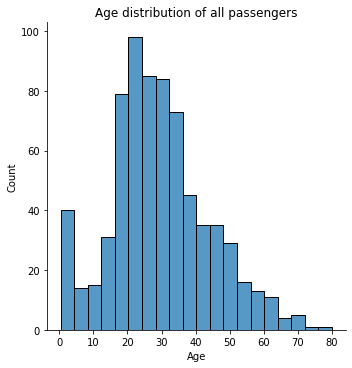

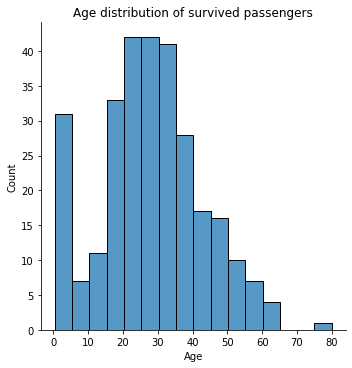

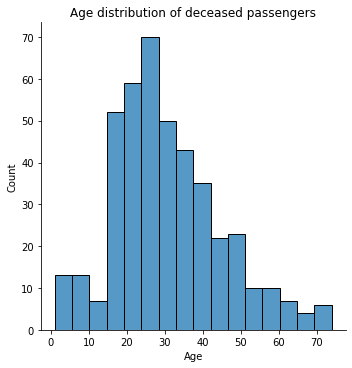

In [ ]:
sns.displot(data, x = 'Age').set(title = 'Age distribution of all passengers')
surv = data.loc[data.Survived == 1]
dead = data.loc[data.Survived == 0]
sns.displot(surv, x='Age').set(title = 'Age distribution of survived passengers')
sns.displot(dead, x='Age').set(title = 'Age distribution of deceased passengers')
print(f"Average and median age of survived passengers: {surv['Age'].mean()} {surv['Age'].median()}")
print(f"Average and median age of deceased passengers: {dead['Age'].mean()} {dead['Age'].median()}")
#plt.bar(distr.index, distr.values)
#plt.show()
#surv = data.loc[data.Survived == 1]
#distr = surv.groupby('Age').count().max(axis=1)
#plt.bar(distr.index, distr.values)
#plt.show()


Как видим из исследования, разница в возрасте почти не имеет значения.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [ ]:
for pclass in set(data.Pclass.values):
  count_survival = len(data.loc[(data.Pclass == pclass) & (data.Survived == 1)])
  count_all = len(data.loc[(data.Pclass == pclass)])
  print(f"Probability survive in {pclass} class is {count_survival / count_all}")
for port in set(filter(lambda x: x == x , set(data.Embarked.values))):
  count_survival = len(data.loc[(data.Embarked == port) & (data.Survived == 1)])
  count_all = len(data.loc[(data.Embarked == port)])
  print(f"Probability survive in {port} port is {count_survival / count_all}")


Probability survive in 1 class is 0.6296296296296297
Probability survive in 2 class is 0.47282608695652173
Probability survive in 3 class is 0.24236252545824846
Probability survive in S port is 0.33695652173913043
Probability survive in Q port is 0.38961038961038963
Probability survive in C port is 0.5535714285714286


Самый безопасный класс 1ый, большинство выживших в Cherbourg, меньшинство в Southampton.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [ ]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)


         column_name  percent_missing
Survived    Survived         0.000000
Pclass        Pclass         0.000000
Name            Name         0.000000
Sex              Sex         0.000000
Age              Age        19.865320
SibSp          SibSp         0.000000
Parch          Parch         0.000000
Ticket        Ticket         0.000000
Fare            Fare         0.000000
Cabin          Cabin        77.104377
Embarked    Embarked         0.224467


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Использование медианы(очень плохо, но быстро), использование наиболее частых характеристик(может внести систематическую ошибку), использование knn.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [ ]:
y = data['Survived']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
neigh = LogisticRegression(max_iter=50000, random_state = 0)
x= train_data.drop(labels = ['Survived', 'Ticket'], axis = 1)

x = process_family(x)
x = process_embarked(x)
x = process_sex(x)
x = process_cabin(x)
x = get_titles(x)
x = process_names(x)
#x = process_pclass(x)
#x = process_ticket(x)
x = pd.get_dummies(x)


x = x.fillna(method='ffill')


cv_scores = cross_val_score(neigh, x, y, cv=5)
print(cv_scores.mean())

0.8271671583704727


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Попробуем дату инженерию на максималках

разобьем семьи на чанки

In [ ]:
def process_family(df):
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    df['Singleton'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallFamily'] = df['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df['LargeFamily'] = df['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    return df

разобьем pclass на отдельные переменные

In [ ]:
def process_pclass(df):
    pclass_dummies = pd.get_dummies(df['Pclass'], prefix="Pclass")
    df = pd.concat([df, pclass_dummies],axis=1)
    df.drop('Pclass',axis=1,inplace=True)
    return df

также сделаем с embarked и пустые клетки заполним sкой, т.к наиболее встречаемая

In [ ]:
def process_embarked(df):
    df.Embarked.fillna('S', inplace=True)
    embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
    df = pd.concat([df, embarked_dummies], axis=1)
    df.drop('Embarked', axis=1, inplace=True)
    return df

пол заполним цифрой, без разбиения. Почему? Потому что дает больший результат))

In [ ]:
def process_sex(df):
    df['Sex'] = df['Sex'].map({'male':1, 'female':0})
    return df

In [ ]:
def process_cabin(df):    
   df.Cabin.fillna('U', inplace=True)
   df['Cabin'] = df['Cabin'].map(lambda c: c[0])
   cabin_dummies = pd.get_dummies(df['Cabin'], prefix='Cabin')    
   df = pd.concat([df, cabin_dummies], axis=1)
   df.drop('Cabin', axis=1, inplace=True)
   return df

обработаем билеты

In [ ]:
def process_ticket(df):
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    df['Ticket'] = df['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(df['Ticket'], prefix='Ticket')
    df = pd.concat([df, tickets_dummies], axis=1)
    df.drop('Ticket', inplace=True, axis=1)
    return df

а имена разделим тоже на чанки

In [ ]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles(df):
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    df['Title'] = df.Title.map(Title_Dictionary)
    return df

In [ ]:
def process_names(df):
    df.drop('Name', axis=1, inplace=True)
    titles_dummies = pd.get_dummies(df['Title'], prefix='Title')
    df = pd.concat([df, titles_dummies], axis=1)
    df.drop('Title', axis=1, inplace=True)
    return df

In [ ]:
y = data['Survived']
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
neigh = LogisticRegression()
x=data.drop(labels = ['Survived', 'Name', 'SibSp', 'Cabin', 'Ticket'], axis = 1)
x = pd.get_dummies(x)
x = x.fillna(method='bfill')
x = StandardScaler().fit_transform(x)
cv_scores = cross_val_score(neigh, x, y, cv=5)
print(cv_scores.mean())

0.7856506182913815


Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [ ]:
neigh = LogisticRegression(random_state=42, max_iter=50000)
x = train_data.copy()
X = test_data.copy()
x = x.drop(labels=['Survived', 'Ticket'], axis = 1)
X = X.drop(labels=[ 'Ticket'], axis = 1)
x = process_family(x)
x = process_embarked(x)
x = process_sex(x)
x = process_cabin(x)
x = get_titles(x)
x = process_names(x)
X = process_family(X)
X = process_embarked(X)
X = process_sex(X)
X = process_cabin(X)
X = get_titles(X)
X = process_names(X)
x = pd.get_dummies(x)
X = pd.get_dummies(X)
features = X.columns
x = x[features]
X = X[features]
x = x.fillna(method = 'ffill')
X = X.fillna(method = 'ffill')
clf = RandomForestClassifier(random_state=42)
clf = clf.fit(x, y)
model = SelectFromModel(clf, prefit=True)
x = model.transform(x)
X = model.transform(X)
neigh.fit(x,y)
predictions = neigh.predict(X)
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': predictions})
output.to_csv('y_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


SCORE: 0.78229 ник nougat11
Какие бы подходы не делал, на логистической регрессии выше 0.794 прыгнуть не удалось. Классификатор не бустил, ибо бусты его работают не стабильно

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [ ]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [ ]:
insurance_data.head()

Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [ ]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

Коэффициент джини - это отношение между площадью кривой и диагональю.

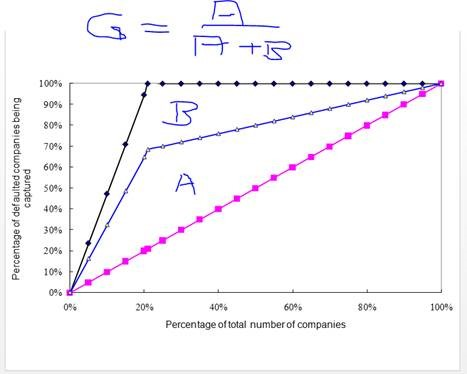

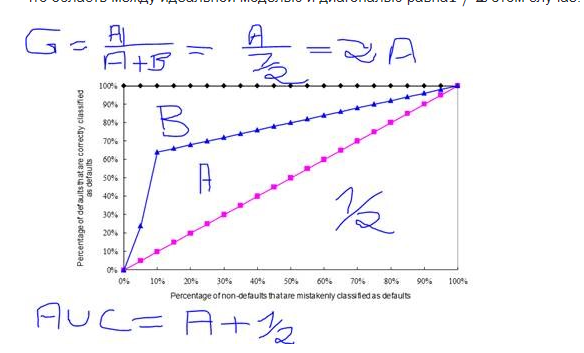

A = G/2 G = 2 * AUC - 1

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

Итоговый коэффицинет подсчитывается как коэффициент gini, а с ним связан auc => по моему мнению другие метирки использовать бесполезно

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code

Sorry, HDD R.I.P